# Porting a PyTorch model to JAX

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jax-ml/jax-ai-stack/blob/main/docs/source/JAX_porting_PyTorch_model.ipynb)

**Note: On Colab we recommend running this on a T4 GPU instance.  On Kaggle we recommend a T4x2 or P100 instance.**

In this tutorial we will learn how to port a PyTorch model to JAX and [Flax](https://flax.readthedocs.io/en/latest/nnx_basics.html). Flax provides an API very similar to the PyTorch `torch.nn` module and porting PyTorch models is rather straightforward. To install Flax, we can simply execute the following command: `pip install -U flax treescope`.

In [1]:
!pip install -Uq flax treescope

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.2/424.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 10.7 MB/s eta 0:00:00


Say we have a trained PyTorch computer-vision model to classify images that we would like to port to JAX. We will use [`TorchVision`](https://pytorch.org/vision/stable/index.html) to provide a [MaxVit](https://pytorch.org/vision/stable/models/maxvit.html) model trained on ImageNet (MaxViT: Multi-Axis Vision Transformer, https://arxiv.org/abs/2204.01697).

First, we set up the model using TorchVision and explore briefly the model's architecture and the blocks we need to port. Next, we define equivalent blocks and the whole model using Flax. After that, we port the weights. Finally, we run some tests to ensure the correctness of the ported model.

In [2]:
import jax
import jax.numpy as jnp
from flax import nnx

## MaxViT PyTorch model setup

### Model's architecture

The MaxVit model is [implemented in TorchVision](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L568). If we inspect the [forward pass](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L707-L712) of the model, we can see that it contains three high-level parts:
- [stem](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L641-L655): a few convolutions, batchnorms, GELU activations.
- [blocks](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L672-L692): list of MaxViT blocks
- [classifier](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L696-L703): adaptive average pooling, few linear layers and Tanh activation.

In [3]:
from torchvision.models import maxvit_t, MaxVit_T_Weights

torch_model = maxvit_t(weights=MaxVit_T_Weights.IMAGENET1K_V1)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://download.pytorch.org/models/maxvit_t-bc5ab103.pth" to /root/.cache/torch/hub/checkpoints/maxvit_t-bc5ab103.pth
100%|██████████| 119M/119M [00:02<00:00, 53.9MB/s]


We can use `flax.nnx.display` to display the model's architecture:

In [4]:
# nnx.display(torch_model)

We can see that there are four MaxViT blocks in the model and each block contains:
- MaxViT layers: two layers for blocks 0, 1, 3 and five layers for the block 4

In [5]:
len(torch_model.blocks), [len(b.layers) for b in torch_model.blocks]

(4, [2, 2, 5, 2])

A [MaxViT layer](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L386) is composed of: [`MBConv`](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L53), `window_attention` as [`PartitionAttentionLayer`](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L282) and `grid_attention` as `PartitionAttentionLayer`.

In [6]:
[[mod.__class__.__name__ for mod in maxvit_layer.layers] for b in torch_model.blocks for maxvit_layer in b.layers]

[['MBConv', 'PartitionAttentionLayer', 'PartitionAttentionLayer'],
 ['MBConv', 'PartitionAttentionLayer', 'PartitionAttentionLayer'],
 ['MBConv', 'PartitionAttentionLayer', 'PartitionAttentionLayer'],
 ['MBConv', 'PartitionAttentionLayer', 'PartitionAttentionLayer'],
 ['MBConv', 'PartitionAttentionLayer', 'PartitionAttentionLayer'],
 ['MBConv', 'PartitionAttentionLayer', 'PartitionAttentionLayer'],
 ['MBConv', 'PartitionAttentionLayer', 'PartitionAttentionLayer'],
 ['MBConv', 'PartitionAttentionLayer', 'PartitionAttentionLayer'],
 ['MBConv', 'PartitionAttentionLayer', 'PartitionAttentionLayer'],
 ['MBConv', 'PartitionAttentionLayer', 'PartitionAttentionLayer'],
 ['MBConv', 'PartitionAttentionLayer', 'PartitionAttentionLayer']]

### Inference on data

Let's check the model on dummy input and on a real image

In [7]:
import torch

torch_model.eval()
with torch.inference_mode():
    x = torch.rand(2, 3, 224, 224)
    output = torch_model(x)

print(output.shape)  # (2, 1000)

torch.Size([2, 1000])


We can download an image of a Pembroke Corgy dog from [TorchVision's gallery](https://github.com/pytorch/vision/blob/main/gallery/assets/dog1.jpg?raw=true) together with [ImageNet classes dictionary](https://raw.githubusercontent.com/pytorch/vision/refs/heads/main/gallery/assets/imagenet_class_index.json):

In [8]:
%%bash
if [ -f "dog1.jpg" ]; then
  echo "dog1.jpg already exists."
else
  wget -nv "https://github.com/pytorch/vision/blob/main/gallery/assets/dog1.jpg?raw=true" -O dog1.jpg
fi
if [ -f "imagenet_class_index.json" ]; then
  echo "imagenet_class_index.json already exists."
else
  wget -nv "https://raw.githubusercontent.com/pytorch/vision/refs/heads/main/gallery/assets/imagenet_class_index.json" -O imagenet_class_index.json
fi

2025-01-15 21:10:00 URL:https://raw.githubusercontent.com/pytorch/vision/refs/heads/main/gallery/assets/dog1.jpg [97422/97422] -> "dog1.jpg" [1]
2025-01-15 21:10:01 URL:https://raw.githubusercontent.com/pytorch/vision/refs/heads/main/gallery/assets/imagenet_class_index.json [35364/35364] -> "imagenet_class_index.json" [1]


Prediction for the Dog: ['n02113023', 'Pembroke'], score: 0.7800846099853516


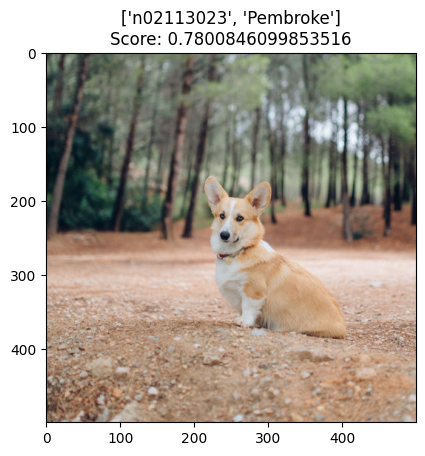

In [9]:
import matplotlib.pyplot as plt

import json
from torchvision.io import read_image


preprocess = MaxVit_T_Weights.IMAGENET1K_V1.transforms()

with open("imagenet_class_index.json") as labels_file:
  labels = json.load(labels_file)


dog1 = read_image("dog1.jpg")
tensor = preprocess(dog1)

torch_model.eval()
with torch.inference_mode():
  output = torch_model(tensor.unsqueeze(dim=0))

class_id = output.argmax(dim=1).item()

print(f"Prediction for the Dog: {labels[str(class_id)]}, score: {output.softmax(dim=-1)[0, class_id]}")

plt.title(f"{labels[str(class_id)]}\nScore: {output.softmax(dim=-1)[0, class_id]}")
plt.imshow(dog1.permute(1, 2, 0))

## Port MaxViT model to JAX

To port the [PyTorch implementation of the MaxVit model](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L568) in JAX using the Flax module, we will implement the following required modules:

- `MaxViT`
  - `MaxVitBlock`
    - `MaxVitLayer`
      - `MBConv`
        - `Conv2dNormActivation`
        - `SqueezeExcitation`
      - `PartitionAttentionLayer`
        - `RelativePositionalMultiHeadAttention`
        - `WindowDepartition`
        - `WindowPartition`
        - `SwapAxes`
        - `StochasticDepth`

The Flax NNX module is very similar to PyTorch `torch.nn` module and we can map the following modules between PyTorch and Flax:
- `nn.Sequential` and `nn.ModuleList` -> `nnx.Sequential`
- `nn.Linear` -> `nnx.Linear`
- `nn.Conv2d` -> `nnx.Conv`
- `nn.BatchNorm2d` -> `nnx.BatchNorm`
- Activations like `nn.ReLU` -> `nnx.relu`
- Pooling layers like `nn.AvgPool2d(...)` -> `lambda x: nnx.avg_pool(x, ...)`
- `nn.AdaptiveAvgPool2d(1)` -> `lambda x: nnx.avg_pool(x, (x.shape[1], x.shape[2]))`, x is in NHWC format
- `nn.Flatten()` -> `lambda x: x.reshape(x.shape[0], -1)`


If the PyTorch model defines a learnable parameter and a buffer:
```python
class Model(nn.Module):
    def __init__(self, ...):
        ...
        self.p = nn.Parameter(torch.ones(10))
        self.register_buffer("b", torch.ones(5))
```
an equivalent code in Flax would be
```python
class Buffer(nnx.Variable):
    pass


class Model(nnx.Module):
    def __init__(self, ...):
        ...
        self.p = nnx.Param(jnp.ones((10,)))
        self.b = Buffer(jnp.ones(5))
```

To inspect NNX module's learnable parameters and buffers, we can use `nnx.state`:
```python
nnx_module = ...
for k, v in nnx.state(nnx_module, nnx.Param).flat_state().items():
    print(
        k,
        v.value.mean() if v.value is not None else None
    )

for k, v in nnx.state(nnx_module, (nnx.BatchStat, Buffer)).flat_state().items():
    print(
        k,
        v.value.mean() if v.value.dtype == "float32" else v.value.sum()
    )
```
The equivalent PyTorch code is:
```python
torch_module = ...

for m, p in torch_module.named_parameters():
    print(m, p.detach().mean())

for m, b in torch_module.named_buffers():
    print(
        m,
        b.mean() if b.dtype == torch.float32 else b.sum()
    )
```

Please note some differences between `torch.nn` and Flax when porting models:
- We should pass `rngs` to all NNX modules with parameters: e.g. `nnx.Linear(..., rngs=nnx.Rngs(0))`
- For a 2D convolution:
  - In Flax, we need to explicitly define `kernel_size`, `strides` as two ints tuples, e.g. `(3, 3)`
  - If PyTorch code defines `padding` as integer, e.g. 2, in Flax it should be explicitly defined as a tuple of two ints per dimension, i.e. `((2, 2), (2, 2))`.
- For a batch normalization: `momentum` value in `torch.nn` should be defined as `1.0 - momentum` in Flax.
- 4D input arrays in Flax should be in NHWC format, i.e. of shape (N, H, W, C) compared to NCHW format (or (N, C, H, W) shape) in PyTorch.

Below we implement one by one all the modules from the above list and add simple forward pass checks.
Let's first implement equivalent of `nn.Identity`.

In [10]:
class Identity(nnx.Module):
    def __call__(self, x: jax.Array) -> jax.Array:
        return x

### `Conv2dNormActivation` implementation

[PyTorch source implementation](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/ops/misc.py#L125).

In [11]:
from typing import Callable, List, Optional, Tuple
from flax import nnx


class Conv2dNormActivation(nnx.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 3,
        stride: int = 1,
        padding: Optional[int] = None,
        groups: int = 1,
        norm_layer: Callable[..., nnx.Module] = nnx.BatchNorm,
        activation_layer: Callable = nnx.relu,
        dilation: int = 1,
        bias: Optional[bool] = None,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        self.out_channels = out_channels

        if padding is None:
            padding = (kernel_size - 1) // 2 * dilation
        if bias is None:
            bias = norm_layer is None

        # sequence integer pairs that give the padding to apply before
        # and after each spatial dimension
        padding = ((padding, padding), (padding, padding))

        layers = [
            nnx.Conv(
                in_channels,
                out_channels,
                kernel_size=(kernel_size, kernel_size),
                strides=(stride, stride),
                padding=padding,
                kernel_dilation=(dilation, dilation),
                feature_group_count=groups,
                use_bias=bias,
                rngs=rngs,
            )
        ]

        if norm_layer is not None:
            layers.append(norm_layer(out_channels, rngs=rngs))

        if activation_layer is not None:
            layers.append(activation_layer)

        super().__init__(*layers)

In [12]:
x = jnp.ones((4, 28, 28, 32))
mod = Conv2dNormActivation(32, 64, 3, 2, 1)
y = mod(x)
print(y.shape)

(4, 14, 14, 64)


### `SqueezeExcitation` implementation

[PyTorch source implementation](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/ops/misc.py#L224).

In [13]:
class SqueezeExcitation(nnx.Module):
    def __init__(
        self,
        input_channels: int,
        squeeze_channels: int,
        activation: Callable = nnx.relu,
        scale_activation: Callable = nnx.sigmoid,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        self.avgpool = nnx.avg_pool
        self.fc1 = nnx.Conv(input_channels, squeeze_channels, (1, 1), rngs=rngs)
        self.fc2 = nnx.Conv(squeeze_channels, input_channels, (1, 1), rngs=rngs)
        self.activation = activation
        self.scale_activation = scale_activation

    def _scale(self, x: jax.Array) -> jax.Array:
        scale = self.avgpool(x, (x.shape[1], x.shape[2]))
        scale = self.fc1(scale)
        scale = self.activation(scale)
        scale = self.fc2(scale)
        return self.scale_activation(scale)

    def __call__(self, x: jax.Array) -> jax.Array:
        scale = self._scale(x)
        return scale * x

In [14]:
x = jnp.ones((4, 28, 28, 32))
mod = SqueezeExcitation(32, 4)
y = mod(x)
print(y.shape)

(4, 28, 28, 32)


### `StochasticDepth` implementation

[PyTorch source implementation](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/ops/stochastic_depth.py#L50).

In [15]:
def stochastic_depth(
    x: jax.Array,
    p: float,
    mode: str,
    deterministic: bool = False,
    rngs: nnx.Rngs = nnx.Rngs(0),
) -> jax.Array:
    if p < 0.0 or p > 1.0:
        raise ValueError(f"drop probability has to be between 0 and 1, but got {p}")
    if mode not in ["batch", "row"]:
        raise ValueError(f"mode has to be either 'batch' or 'row', but got {mode}")
    if deterministic or p == 0.0:
        return x

    survival_rate = 1.0 - p
    if mode == "row":
        size = [x.shape[0]] + [1] * (x.ndim - 1)
    else:
        size = [1] * x.ndim

    noise = jax.random.bernoulli(
        rngs.dropout(), p=survival_rate, shape=size
    ).astype(dtype=x.dtype)

    if survival_rate > 0.0:
        noise = noise / survival_rate

    return x * noise


class StochasticDepth(nnx.Module):
    def __init__(
        self,
        p: float,
        mode: str,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        self.p = p
        self.mode = mode
        self.deterministic = False
        self.rngs = rngs

    def __call__(self, x: jax.Array) -> jax.Array:
        return stochastic_depth(
            x, self.p, self.mode, self.deterministic, rngs=self.rngs
        )

In [16]:
x = jnp.ones((4, 28, 28, 32))
mod = StochasticDepth(0.5, "row")

mod.eval()
y = mod(x)
assert (y == x).all()

mod.train()
y = mod(x)
assert (y != x).any()

### `MBConv` implementation

[PyTorch source implementation](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L53)

In [17]:
class MBConv(nnx.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        expansion_ratio: float,
        squeeze_ratio: float,
        stride: int,
        activation_layer: Callable,
        norm_layer: Callable[..., nnx.Module],
        p_stochastic_dropout: float = 0.0,
        rngs = nnx.Rngs(0),
    ):
        should_proj = stride != 1 or in_channels != out_channels
        if should_proj:
            proj = [nnx.Conv(
                in_channels, out_channels, kernel_size=(1, 1), strides=(1, 1), use_bias=True, rngs=rngs
            )]
            if stride == 2:
                padding = ((1, 1), (1, 1))
                proj = [
                    lambda x: nnx.avg_pool(
                        x, window_shape=(3, 3), strides=(stride, stride), padding=padding
                    )
                ] + proj
            self.proj = nnx.Sequential(*proj)
        else:
            self.proj = Identity()

        mid_channels = int(out_channels * expansion_ratio)
        sqz_channels = int(out_channels * squeeze_ratio)

        if p_stochastic_dropout:
            self.stochastic_depth = StochasticDepth(p_stochastic_dropout, mode="row", rngs=rngs)
        else:
            self.stochastic_depth = Identity()

        _layers = [
            norm_layer(in_channels, rngs=rngs),  # pre_norm
            Conv2dNormActivation(    # conv_a
                in_channels,
                mid_channels,
                kernel_size=1,
                stride=1,
                padding=0,
                activation_layer=activation_layer,
                norm_layer=norm_layer,
                rngs=rngs,
            ),
            Conv2dNormActivation(  # conv_b
                mid_channels,
                mid_channels,
                kernel_size=3,
                stride=stride,
                padding=1,
                activation_layer=activation_layer,
                norm_layer=norm_layer,
                groups=mid_channels,
                rngs=rngs,
            ),
            SqueezeExcitation(  # squeeze_excitation
                mid_channels, sqz_channels, activation=nnx.silu, rngs=rngs
            ),
            nnx.Conv(  # conv_c
                mid_channels, out_channels, kernel_size=(1, 1), use_bias=True, rngs=rngs
            )
        ]
        self.layers = nnx.Sequential(*_layers)

    def __call__(self, x: jax.Array) -> jax.Array:
        res = self.proj(x)
        x = self.stochastic_depth(self.layers(x))
        return res + x

In [18]:
from functools import partial

norm_layer = partial(nnx.BatchNorm, epsilon=1e-3, momentum=0.99)
x = jnp.ones((4, 28, 28, 32))
mod = MBConv(32, 64, 4, 0.25, 2, activation_layer=nnx.gelu, norm_layer=norm_layer)
y = mod(x)
y.shape

(4, 14, 14, 64)

### `RelativePositionalMultiHeadAttention` implementation

[PyTorch source implementation](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L140). First we reimplement a helper function `_get_relative_position_index`:

In [19]:
def _get_relative_position_index(height: int, width: int) -> jax.Array:
    # PyTorch code:
    # coords = torch.stack(torch.meshgrid([torch.arange(height), torch.arange(width)]))

    coords = jnp.stack(
        jnp.meshgrid(*[jnp.arange(height), jnp.arange(width)], indexing="ij")
    )
    # PyTorch code: coords_flat = torch.flatten(coords, 1)
    coords_flat = coords.reshape(coords.shape[0], -1)

    relative_coords = coords_flat[:, :, None] - coords_flat[:, None, :]
    relative_coords = jnp.permute_dims(relative_coords, (1, 2, 0))

    # PyTorch code:
    # relative_coords[:, :, 0] += height - 1
    # relative_coords[:, :, 1] += width - 1
    # relative_coords[:, :, 0] *= 2 * width - 1
    relative_coords = relative_coords + jnp.array((height - 1, width - 1))
    relative_coords = relative_coords * jnp.array((2 * width - 1, 1))

    return relative_coords.sum(-1)

Let us check our implementation against PyTorch implementation:

In [20]:
from torchvision.models.maxvit import _get_relative_position_index as pytorch_get_relative_position_index


output = _get_relative_position_index(13, 12)
expected = pytorch_get_relative_position_index(13, 12)
assert (output == jnp.asarray(expected)).all()

Next, we can port `RelativePositionalMultiHeadAttention` module which a learnable parameter and a buffer:

In [21]:
import math


class Buffer(nnx.Variable):
    pass


class RelativePositionalMultiHeadAttention(nnx.Module):
    def __init__(
        self,
        feat_dim: int,
        head_dim: int,
        max_seq_len: int,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        if feat_dim % head_dim != 0:
            raise ValueError(f"feat_dim: {feat_dim} must be divisible by head_dim: {head_dim}")

        self.n_heads = feat_dim // head_dim
        self.head_dim = head_dim
        self.size = int(math.sqrt(max_seq_len))
        self.max_seq_len = max_seq_len

        self.to_qkv = nnx.Linear(feat_dim, self.n_heads * self.head_dim * 3, rngs=rngs)
        self.scale_factor = feat_dim**-0.5

        self.merge = nnx.Linear(self.head_dim * self.n_heads, feat_dim, rngs=rngs)

        self.relative_position_index = Buffer(_get_relative_position_index(self.size, self.size))

        # initialize with truncated normal bias
        initializer = jax.nn.initializers.truncated_normal(stddev=0.02)
        shape = ((2 * self.size - 1) * (2 * self.size - 1), self.n_heads)
        self.relative_position_bias_table = nnx.Param(initializer(rngs.params(), shape, jnp.float32))

    def get_relative_positional_bias(self) -> jax.Array:
        bias_index = self.relative_position_index.value.ravel()
        relative_bias = self.relative_position_bias_table[bias_index].reshape((self.max_seq_len, self.max_seq_len, -1))
        relative_bias = jnp.permute_dims(relative_bias, (2, 0, 1))
        return jnp.expand_dims(relative_bias, axis=0)

    def __call__(self, x: jax.Array) -> jax.Array:
        B, G, P, D = x.shape
        H, DH = self.n_heads, self.head_dim

        qkv = self.to_qkv(x)

        q, k, v = jnp.split(qkv, 3, axis=-1)
        q = jnp.permute_dims(q.reshape((B, G, P, H, DH)), (0, 1, 3, 2, 4))
        k = jnp.permute_dims(k.reshape((B, G, P, H, DH)), (0, 1, 3, 2, 4))
        v = jnp.permute_dims(v.reshape((B, G, P, H, DH)), (0, 1, 3, 2, 4))

        k = k * self.scale_factor

        dot_prod = jnp.einsum("B G H I D, B G H J D -> B G H I J", q, k)
        pos_bias = self.get_relative_positional_bias()

        dot_prod = jax.nn.softmax(dot_prod + pos_bias, axis=-1)

        out = jnp.einsum("B G H I J, B G H J D -> B G H I D", dot_prod, v)
        out = jnp.permute_dims(out, (0, 1, 3, 2, 4)).reshape((B, G, P, D))

        out = self.merge(out)
        return out

In [22]:
x = jnp.ones((4, 32, 49, 64))

mod = RelativePositionalMultiHeadAttention(64, 16, 49)
y = mod(x)
print(y.shape)

(4, 32, 49, 64)


### `SwapAxes`, `WindowPartition`, `WindowDepartition` implementations

[PyTorch source implementation](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L213).

In [23]:
class SwapAxes(nnx.Module):
    def __init__(self, a: int, b: int):
        self.a = a
        self.b = b

    def __call__(self, x: jax.Array) -> jax.Array:
        res = jnp.swapaxes(x, self.a, self.b)
        return res


class WindowPartition(nnx.Module):
    def __call__(self, x: jax.Array, p: int) -> jax.Array:
        # Output array with expected layout of [B, H/P, W/P, P*P, C].
        B, H, W, C = x.shape
        P = p
        # chunk up H and W dimensions
        x = x.reshape((B, H // P, P, W // P, P, C))
        x = jnp.permute_dims(x, (0, 1, 3, 2, 4, 5))
        # colapse P * P dimension
        x = x.reshape((B, (H // P) * (W // P), P * P, C))
        return x


class WindowDepartition(nnx.Module):
    def __call__(self, x: jax.Array, p: int, h_partitions: int, w_partitions: int) -> jax.Array:
        # Output array with expected layout of [B, H, W, C].
        B, G, PP, C = x.shape
        P = p
        HP, WP = h_partitions, w_partitions
        # split P * P dimension into 2 P tile dimensions
        x = x.reshape((B, HP, WP, P, P, C))
        # permute into B, HP, P, WP, P, C
        x = jnp.permute_dims(x, (0, 1, 3, 2, 4, 5))
        # reshape into B, H, W, C
        x = x.reshape((B, HP * P, WP * P, C))
        return x

In [24]:
x = jnp.ones((3, 4, 5, 6))
mod = SwapAxes(1, 2)
y = mod(x)
assert y.shape == (3, 5, 4, 6)

x = jnp.ones((4, 128, 128, 3))
mod = WindowPartition()
y = mod(x, p=16)
assert y.shape == (4, (128 // 16) * (128 // 16), 16 * 16, 3)

x = jnp.ones((4, (128 // 16) * (128 // 16), 16 * 16, 3))
mod = WindowDepartition()
y = mod(x, p=16, h_partitions=128 // 16, w_partitions=128 // 16)
assert y.shape == (4, 128, 128, 3)

### `PartitionAttentionLayer` implementation

[PyTorch source implementation](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L282).

In [25]:
class PartitionAttentionLayer(nnx.Module):
    """
    Layer for partitioning the input tensor into non-overlapping windows and
    applying attention to each window.
    """
    def __init__(
        self,
        in_channels: int,
        head_dim: int,
        # partitioning parameters
        partition_size: int,
        partition_type: str,
        # grid size needs to be known at initialization time
        # because we need to know hamy relative offsets there are in the grid
        grid_size: Tuple[int, int],
        mlp_ratio: int,
        activation_layer: Callable,
        norm_layer: Callable[..., nnx.Module],
        attention_dropout: float,
        mlp_dropout: float,
        p_stochastic_dropout: float,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        self.n_heads = in_channels // head_dim
        self.head_dim = head_dim
        self.n_partitions = grid_size[0] // partition_size
        self.partition_type = partition_type
        self.grid_size = grid_size

        if partition_type not in ["grid", "window"]:
            raise ValueError("partition_type must be either 'grid' or 'window'")

        if partition_type == "window":
            self.p, self.g = partition_size, self.n_partitions
        else:
            self.p, self.g = self.n_partitions, partition_size

        self.partition_op = WindowPartition()
        self.departition_op = WindowDepartition()
        self.partition_swap = SwapAxes(-2, -3) if partition_type == "grid" else Identity()
        self.departition_swap = SwapAxes(-2, -3) if partition_type == "grid" else Identity()

        self.attn_layer = nnx.Sequential(
            norm_layer(in_channels, rngs=rngs),
            # it's always going to be partition_size ** 2 because
            # of the axis swap in the case of grid partitioning
            RelativePositionalMultiHeadAttention(
                in_channels, head_dim, partition_size**2, rngs=rngs
            ),
            nnx.Dropout(attention_dropout, rngs=rngs),
        )

        # pre-normalization similar to transformer layers
        self.mlp_layer = nnx.Sequential(
            nnx.LayerNorm(in_channels, rngs=rngs),
            nnx.Linear(in_channels, in_channels * mlp_ratio, rngs=rngs),
            activation_layer,
            nnx.Linear(in_channels * mlp_ratio, in_channels, rngs=rngs),
            nnx.Dropout(mlp_dropout, rngs=rngs),
        )

        # layer scale factors
        self.stochastic_dropout = StochasticDepth(p_stochastic_dropout, mode="row", rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        # Undefined behavior if H or W are not divisible by p
        # https://github.com/google-research/maxvit/blob/da76cf0d8a6ec668cc31b399c4126186da7da944/maxvit/models/maxvit.py#L766
        gh, gw = self.grid_size[0] // self.p, self.grid_size[1] // self.p
        torch._assert(
            self.grid_size[0] % self.p == 0 and self.grid_size[1] % self.p == 0,
            "Grid size must be divisible by partition size. Got grid size of {} and partition size of {}".format(
                self.grid_size, self.p
            ),
        )
        x = self.partition_op(x, self.p)  # (B, H, W, C) -> (B, H/P, W/P, P*P, C)
        x = self.partition_swap(x)  # -> grid: (B, H/P, P*P, W/P, C)
        x = x + self.stochastic_dropout(self.attn_layer(x))
        x = x + self.stochastic_dropout(self.mlp_layer(x))
        x = self.departition_swap(x)  # grid: (B, H/P, P*P, W/P, C) -> (B, H/P, W/P, P*P, C)
        x = self.departition_op(x, self.p, gh, gw)  # -> (B, H, W, C)

        return x

In [26]:
x = jnp.ones((4, 224, 224, 36))

grid_size = (224, 224)
mod = PartitionAttentionLayer(
    36, 6, 7, "window", grid_size=grid_size, mlp_ratio=4,
    activation_layer=nnx.gelu, norm_layer=nnx.LayerNorm,
    attention_dropout=0.4, mlp_dropout=0.3, p_stochastic_dropout=0.2,
)

y = mod(x)
print(y.shape)

mod = PartitionAttentionLayer(
    36, 6, 7, "grid", grid_size=grid_size, mlp_ratio=4,
    activation_layer=nnx.gelu, norm_layer=nnx.LayerNorm,
    attention_dropout=0.4, mlp_dropout=0.3, p_stochastic_dropout=0.2,
)

y = mod(x)
print(y.shape)

(4, 224, 224, 36)
(4, 224, 224, 36)


### `MaxVitLayer` implementation

[PyTorch source implementation](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L386).

In [27]:
class MaxVitLayer(nnx.Module):
    """
    MaxVit layer consisting of a MBConv layer followed by a PartitionAttentionLayer with `window`
    and a PartitionAttentionLayer with `grid`.
    """
    def __init__(
        self,
        # conv parameters
        in_channels: int,
        out_channels: int,
        squeeze_ratio: float,
        expansion_ratio: float,
        stride: int,
        # conv + transformer parameters
        norm_layer: Callable[..., nnx.Module],
        activation_layer: Callable,
        # transformer parameters
        head_dim: int,
        mlp_ratio: int,
        mlp_dropout: float,
        attention_dropout: float,
        p_stochastic_dropout: float,
        # partitioning parameters
        partition_size: int,
        grid_size: Tuple[int, int],
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        layers = [
            # convolutional layer
            MBConv(
                in_channels=in_channels,
                out_channels=out_channels,
                expansion_ratio=expansion_ratio,
                squeeze_ratio=squeeze_ratio,
                stride=stride,
                activation_layer=activation_layer,
                norm_layer=norm_layer,
                p_stochastic_dropout=p_stochastic_dropout,
                rngs=rngs,
            ),
            # window_attention
            PartitionAttentionLayer(
                in_channels=out_channels,
                head_dim=head_dim,
                partition_size=partition_size,
                partition_type="window",
                grid_size=grid_size,
                mlp_ratio=mlp_ratio,
                activation_layer=activation_layer,
                norm_layer=nnx.LayerNorm,
                attention_dropout=attention_dropout,
                mlp_dropout=mlp_dropout,
                p_stochastic_dropout=p_stochastic_dropout,
                rngs=rngs,
            ),
            # grid_attention
            PartitionAttentionLayer(
                in_channels=out_channels,
                head_dim=head_dim,
                partition_size=partition_size,
                partition_type="grid",
                grid_size=grid_size,
                mlp_ratio=mlp_ratio,
                activation_layer=activation_layer,
                norm_layer=nnx.LayerNorm,
                attention_dropout=attention_dropout,
                mlp_dropout=mlp_dropout,
                p_stochastic_dropout=p_stochastic_dropout,
                rngs=rngs,
            )
        ]
        self.layers = nnx.Sequential(*layers)

    def __call__(self, x: jax.Array) -> jax.Array:
        return self.layers(x)


def _get_conv_output_shape(
    input_size: Tuple[int, int], kernel_size: int, stride: int, padding: int
) -> Tuple[int, int]:
    return (
        (input_size[0] - kernel_size + 2 * padding) // stride + 1,
        (input_size[1] - kernel_size + 2 * padding) // stride + 1,
    )

In [28]:
x = jnp.ones((4, 224, 224, 3))

grid_size = _get_conv_output_shape((224, 224), kernel_size=3, stride=2, padding=1)
norm_layer = partial(nnx.BatchNorm, epsilon=1e-3, momentum=0.99)

mod = MaxVitLayer(
    3, 36, squeeze_ratio=0.25, expansion_ratio=4,
    stride=2, norm_layer=norm_layer, activation_layer=nnx.gelu,
    head_dim=6, mlp_ratio=4, mlp_dropout=0.5,
    attention_dropout=0.4, p_stochastic_dropout=0.3,
    partition_size=7, grid_size=grid_size,
)

y = mod(x)
print(y.shape)

(4, 112, 112, 36)


### `MaxVitBlock` implementation

[PyTorch source implementation](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L483).

In [29]:
class MaxVitBlock(nnx.Module):
    """
    A MaxVit block consisting of `n_layers` MaxVit layers.
    """
    def __init__(
        self,
        # conv parameters
        in_channels: int,
        out_channels: int,
        squeeze_ratio: float,
        expansion_ratio: float,
        # conv + transformer parameters
        norm_layer: Callable[..., nnx.Module],
        activation_layer: Callable,
        # transformer parameters
        head_dim: int,
        mlp_ratio: int,
        mlp_dropout: float,
        attention_dropout: float,
        # partitioning parameters
        partition_size: int,
        input_grid_size: Tuple[int, int],
        # number of layers
        n_layers: int,
        p_stochastic: List[float],
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        if not len(p_stochastic) == n_layers:
            raise ValueError(f"p_stochastic must have length n_layers={n_layers}, got p_stochastic={p_stochastic}.")

        # account for the first stride of the first layer
        self.grid_size = _get_conv_output_shape(input_grid_size, kernel_size=3, stride=2, padding=1)

        layers = []
        for idx, p in enumerate(p_stochastic):
            stride = 2 if idx == 0 else 1
            layers.append(
                MaxVitLayer(
                    in_channels=in_channels if idx == 0 else out_channels,
                    out_channels=out_channels,
                    squeeze_ratio=squeeze_ratio,
                    expansion_ratio=expansion_ratio,
                    stride=stride,
                    norm_layer=norm_layer,
                    activation_layer=activation_layer,
                    head_dim=head_dim,
                    mlp_ratio=mlp_ratio,
                    mlp_dropout=mlp_dropout,
                    attention_dropout=attention_dropout,
                    partition_size=partition_size,
                    grid_size=self.grid_size,
                    p_stochastic_dropout=p,
                ),
            )
        self.layers = nnx.Sequential(*layers)

    def __call__(self, x: jax.Array) -> jax.Array:
        return self.layers(x)

In [30]:
x = jnp.ones((4, 224, 224, 3))

input_grid_size = (224, 224)
norm_layer = partial(nnx.BatchNorm, epsilon=1e-3, momentum=0.99)

mod = MaxVitBlock(
    3, 36, squeeze_ratio=0.25, expansion_ratio=4,
    norm_layer=norm_layer, activation_layer=nnx.gelu,
    head_dim=6, mlp_ratio=4, mlp_dropout=0.5, attention_dropout=0.4,
    partition_size=7, input_grid_size=input_grid_size,
    n_layers=2,
    p_stochastic=[0.0, 0.2],
)

y = mod(x)
print(y.shape)

(4, 112, 112, 36)


### `MaxVit` implementation

Finally, we can assemble everything together and define the MaxVit model.
[PyTorch source implementation](https://github.com/pytorch/vision/blob/945bdad7523806b15d3740ce6ace2fced9ef9d3b/torchvision/models/maxvit.py#L568).

In [31]:
import numpy as np


def _make_block_input_shapes(input_size: Tuple[int, int], n_blocks: int) -> List[Tuple[int, int]]:
    """Util function to check that the input size is correct for a MaxVit configuration."""
    shapes = []
    block_input_shape = _get_conv_output_shape(input_size, 3, 2, 1)
    for _ in range(n_blocks):
        block_input_shape = _get_conv_output_shape(block_input_shape, 3, 2, 1)
        shapes.append(block_input_shape)
    return shapes


class MaxVit(nnx.Module):
    """
    Implements MaxVit Transformer from the "MaxViT: Multi-Axis Vision Transformer" paper.
    """
    def __init__(
        self,
        # input size parameters
        input_size: Tuple[int, int],
        # stem and task parameters
        stem_channels: int,
        # partitioning parameters
        partition_size: int,
        # block parameters
        block_channels: List[int],
        block_layers: List[int],
        # attention head dimensions
        head_dim: int,
        stochastic_depth_prob: float,
        # conv + transformer parameters
        # norm_layer is applied only to the conv layers
        # activation_layer is applied both to conv and transformer layers
        norm_layer: Optional[Callable[..., nnx.Module]] = None,
        activation_layer: Callable = nnx.gelu,
        # conv parameters
        squeeze_ratio: float = 0.25,
        expansion_ratio: float = 4,
        # transformer parameters
        mlp_ratio: int = 4,
        mlp_dropout: float = 0.0,
        attention_dropout: float = 0.0,
        # task parameters
        num_classes: int = 1000,
        rngs: nnx.Rngs = nnx.Rngs(0),
    ):
        input_channels = 3

        if norm_layer is None:
            norm_layer = partial(nnx.BatchNorm, epsilon=1e-3, momentum=0.99)

        # Make sure input size will be divisible by the partition size in all blocks
        # Undefined behavior if H or W are not divisible by p
        block_input_sizes = _make_block_input_shapes(input_size, len(block_channels))
        for idx, block_input_size in enumerate(block_input_sizes):
            if block_input_size[0] % partition_size != 0 or block_input_size[1] % partition_size != 0:
                raise ValueError(
                    f"Input size {block_input_size} of block {idx} is not divisible by partition size {partition_size}. "
                    f"Consider changing the partition size or the input size.\n"
                    f"Current configuration yields the following block input sizes: {block_input_sizes}."
                )

        # stem
        self.stem = nnx.Sequential(
            Conv2dNormActivation(
                input_channels,
                stem_channels,
                3,
                stride=2,
                norm_layer=norm_layer,
                activation_layer=activation_layer,
                bias=False,
                rngs=rngs,
            ),
            Conv2dNormActivation(
                stem_channels,
                stem_channels,
                3,
                stride=1,
                norm_layer=None,
                activation_layer=None,
                bias=True,
                rngs=rngs,
            ),
        )

        # account for stem stride
        input_size = _get_conv_output_shape(input_size, kernel_size=3, stride=2, padding=1)
        self.partition_size = partition_size

        # blocks
        blocks = []
        in_channels = [stem_channels] + block_channels[:-1]
        out_channels = block_channels

        # precompute the stochastic depth probabilities from 0 to stochastic_depth_prob
        # since we have N blocks with L layers, we will have N * L probabilities uniformly distributed
        # over the range [0, stochastic_depth_prob]
        p_stochastic = np.linspace(0, stochastic_depth_prob, sum(block_layers)).tolist()

        p_idx = 0
        for in_channel, out_channel, num_layers in zip(in_channels, out_channels, block_layers):
            blocks.append(
                MaxVitBlock(
                    in_channels=in_channel,
                    out_channels=out_channel,
                    squeeze_ratio=squeeze_ratio,
                    expansion_ratio=expansion_ratio,
                    norm_layer=norm_layer,
                    activation_layer=activation_layer,
                    head_dim=head_dim,
                    mlp_ratio=mlp_ratio,
                    mlp_dropout=mlp_dropout,
                    attention_dropout=attention_dropout,
                    partition_size=partition_size,
                    input_grid_size=input_size,
                    n_layers=num_layers,
                    p_stochastic=p_stochastic[p_idx : p_idx + num_layers],
                ),
            )
            input_size = blocks[-1].grid_size
            p_idx += num_layers
        self.blocks = nnx.Sequential(*blocks)

        self.classifier = nnx.Sequential(
            lambda x: nnx.avg_pool(x, (x.shape[1], x.shape[2])),  #  nn.AdaptiveAvgPool2d(1)
            lambda x: x.reshape(x.shape[0], -1),  #  nn.Flatten()
            nnx.LayerNorm(block_channels[-1], rngs=rngs),
            nnx.Linear(block_channels[-1], block_channels[-1], rngs=rngs),
            nnx.tanh,
            nnx.Linear(block_channels[-1], num_classes, use_bias=False, rngs=rngs),
        )

        self._init_weights(rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        x = self.stem(x)
        x = self.blocks(x)
        x = self.classifier(x)
        return x

    def _init_weights(self, rngs):
        normal_initializer = nnx.initializers.normal(stddev=0.02)
        for name, module in self.iter_modules():
            if isinstance(module, (nnx.Conv, nnx.Linear)):
                module.kernel.value = normal_initializer(
                    rngs(), module.kernel.value.shape, module.kernel.value.dtype
                )
                if module.bias.value is not None:
                    module.bias.value = jnp.zeros(
                        module.bias.value.shape, dtype=module.bias.value.dtype
                    )
            elif isinstance(module, nnx.BatchNorm):
                module.scale.value = jnp.ones(module.scale.value.shape, module.scale.value.dtype)
                module.bias.value = jnp.zeros(module.bias.value.shape, module.bias.value.dtype)

In [32]:
x = jnp.ones((4, 224, 224, 3))

mod = MaxVit(
    input_size=(224, 224),
    stem_channels=64,
    block_channels=[64, 128, 256, 512],
    block_layers=[2, 2, 5, 2],
    head_dim=32,
    stochastic_depth_prob=0.2,
    partition_size=7,
    num_classes=1000,
)

y = mod(x)
print(y.shape)

(4, 1000)


In [33]:
def maxvit_t(
    input_size=(224, 224),
    stem_channels=64,
    block_channels=[64, 128, 256, 512],
    block_layers=[2, 2, 5, 2],
    head_dim=32,
    stochastic_depth_prob=0.2,
    partition_size=7,
    num_classes=1000,
):
    model = MaxVit(
        input_size=input_size,
        stem_channels=stem_channels,
        block_channels=block_channels,
        block_layers=[2, 2, 5, 2],
        head_dim=head_dim,
        stochastic_depth_prob=stochastic_depth_prob,
        partition_size=partition_size,
        num_classes=num_classes,
    )
    return model

### Test JAX implementation

Let us import equivalent PyTorch modules and check our implementations against PyTorch. Please note that
PyTorch modules will contain random parameters and buffers that we need to set into our Flax implementations.

Below we define a helper class `Torch2Flax` to copy parameters and buffers from a PyTorch module into equivalent Flax module.

In [34]:
import torch.nn as nn


class Torch2Flax:
    @staticmethod
    def conv_params_permute(name, torch_param):
        if name == "weight":
            return torch_param.permute(2, 3, 1, 0)
        return torch_param

    @staticmethod
    def linear_params_permute(name, torch_param):
        if name == "weight":
            return torch_param.permute(1, 0)
        return torch_param

    @staticmethod
    def default_params_transform(name, param):
        return param

    modules_mapping_info = {
        nn.Conv2d: {
            "type": nnx.Conv,
            "params_mapping": {
                "weight": "kernel",
                "bias": "bias",
            },
            "params_transform": conv_params_permute,
        },
        nn.BatchNorm2d: {
            "type": nnx.BatchNorm,
            "params_mapping": {
                "weight": "scale",
                "bias": "bias",
                "running_mean": "mean",
                "running_var": "var",
            },
        },
        nn.Linear: {
            "type": nnx.Linear,
            "params_mapping": {
                "weight": "kernel",
                "bias": "bias",
            },
            "params_transform": linear_params_permute,
        },
        nn.LayerNorm: {
            "type": nnx.LayerNorm,
            "params_mapping": {
                "weight": "scale",
                "bias": "bias",
            },
        }
    } | {
        torch_mod: {
            "type": nnx_fn_type,
            "params_mapping": {},
        } for torch_mod, nnx_fn_type in [
            (nn.Identity, Identity),
            (nn.Flatten, type(lambda x: x)),
            (nn.ReLU, type(nnx.relu)),
            (nn.GELU, type(nnx.gelu)),
            (nn.SELU, type(nnx.selu)),
            (nn.SiLU, type(nnx.silu)),
            (nn.Tanh, type(nnx.tanh)),
            (nn.Dropout, nnx.Dropout),
            (nn.Sigmoid, type(nnx.sigmoid)),
            (nn.AvgPool2d, type(lambda x: nnx.avg_pool(x, (2, 2)))),
            (nn.AdaptiveAvgPool2d, type(lambda x: nnx.avg_pool(x, (x.shape[1], x.shape[2])))),
        ]
    }

    def _copy_params_buffers(self, torch_nn_module, nnx_module):
        torch_module_type = type(torch_nn_module)
        assert torch_module_type in self.modules_mapping_info, torch_module_type
        module_mapping_info = self.modules_mapping_info[torch_module_type]
        assert isinstance(nnx_module, module_mapping_info["type"]), (
            nnx_module, type(nnx_module), module_mapping_info["type"]
        )

        for torch_key, nnx_key in module_mapping_info["params_mapping"].items():

            torch_value = getattr(torch_nn_module, torch_key)
            nnx_param = getattr(nnx_module, nnx_key)
            assert nnx_param is not None, (torch_key, nnx_key, nnx_module)

            if torch_value is None:
                assert nnx_param.value is None, nnx_param
                continue

            params_transform = module_mapping_info.get("params_transform", Torch2Flax.default_params_transform)
            torch_value = params_transform(torch_key, torch_value)

            assert nnx_param.value.shape == torch_value.data.shape, (
                nnx_key, nnx_param.value.shape, torch_key, torch_value.data.shape
            )
            nnx_param.value = jnp.asarray(torch_value.data)

    def _copy_sequential(self, torch_nn_seq, nnx_seq, skip_modules=None):
        assert isinstance(torch_nn_seq, (nn.Sequential, nn.ModuleList)), type(torch_nn_seq)
        assert isinstance(nnx_seq, nnx.Sequential), type(nnx_seq)
        for i, index in enumerate(torch_nn_seq):
            torch_module = torch_nn_seq[i]
            nnx_module = nnx_seq.layers[i]
            self.copy_module(torch_module, nnx_module, skip_modules=skip_modules)

    def copy_module(self, torch_module, nnx_module, skip_modules=None):
        if skip_modules is None:
            skip_modules = []

        if isinstance(torch_module, (nn.Sequential, nn.ModuleList)):
            self._copy_sequential(torch_module, nnx_module, skip_modules=skip_modules)
        elif type(torch_module) in self.modules_mapping_info:
            self._copy_params_buffers(torch_module, nnx_module)
        else:
            if skip_modules is not None:
                if torch_module.__class__.__name__ in skip_modules:
                    return

            named_children = list(torch_module.named_children())
            assert len(named_children) > 0, type(torch_module)
            for name, torch_child in named_children:
                nnx_child = getattr(nnx_module, name, None)
                assert nnx_child is not None, (name, nnx_module)
                self.copy_module(torch_child, nnx_child, skip_modules=skip_modules)
            # Copy buffers and params of the module itself (not its children)
            for name, torch_buffer in torch_module.named_buffers():
                if "." in name:
                    # This is child's buffer
                    continue
                nnx_buffer = getattr(nnx_module, name)
                assert isinstance(nnx_buffer, nnx.Variable), (name, nnx_buffer, nnx_module)

                assert nnx_buffer.value.shape == torch_buffer.shape, (
                    name, nnx_buffer.value.shape, torch_buffer.shape
                )
                nnx_buffer.value = jnp.asarray(torch_buffer)

            for name, torch_param in torch_module.named_parameters():
                if "." in name:
                    # This is child's parameter
                    continue
                nnx_param = getattr(nnx_module, name)
                assert isinstance(nnx_param, nnx.Param), (name, nnx_param, nnx_module)

                assert nnx_param.value.shape == torch_param.data.shape, (
                    name, nnx_param.value.shape, torch_param.data.shape
                )
                nnx_param.value = jnp.asarray(torch_param.data)


def test_modules(
    nnx_module, torch_module, torch_input, atol=1e-3, mode="eval", permute_torch_input=True, device="cuda"
):
    assert torch_input.ndim == 4
    assert mode in ("eval", "train")

    torch_input = torch_input.to(device)
    torch_module = torch_module.to(device)

    if mode == "eval":
        torch_module.eval()
        nnx_module.eval()
    else:
        torch_module.train()
        nnx_module.train()

    with torch.inference_mode(mode=mode=="eval"):
        torch_output = torch_module(torch_input)

    if permute_torch_input:
        torch_input = torch_input.permute(0, 2, 3, 1)

    jax_input = jnp.asarray(torch_input, device=jax.devices(device)[0])
    jax_output = nnx_module(jax_input)
    assert jax_output.device == jax.devices(device)[0]

    torch_output = torch_output.detach()
    if permute_torch_input and torch_output.ndim == 4:
        torch_output = torch_output.permute(0, 2, 3, 1)
    jax_expected = jnp.asarray(torch_output)

    assert jnp.allclose(jax_output, jax_expected, atol=atol), (
        jnp.abs(jax_output - jax_expected).max(),
        jnp.abs(jax_output - jax_expected).mean(),
    )


t2f = Torch2Flax()

Let us now test our JAX modules. We only test the result of the forward pass in the inference mode such that we avoid discrepancies related to random layers like `Dropout`, `StochasticDepth`, etc.
By default, we use absolute error tolerence `1e-3` when comparing the JAX output against expected PyTorch result.
For larger modules we set the device to CPU for the JAX model to execute on in order to reduce the errors between CPU and CUDA.

In [35]:
from torchvision.ops.misc import Conv2dNormActivation as PyTorchConv2dNormActivation


torch_module = PyTorchConv2dNormActivation(32, 64, 3, 2, 1)
nnx_module = Conv2dNormActivation(32, 64, 3, 2, 1)

t2f.copy_module(torch_module, nnx_module)

test_modules(nnx_module, torch_module, torch.randn(4, 32, 46, 46))

In [36]:
from torchvision.ops.misc import SqueezeExcitation as PyTorchSqueezeExcitation


torch_module = PyTorchSqueezeExcitation(32, 4)
nnx_module = SqueezeExcitation(32, 4)

t2f.copy_module(torch_module, nnx_module)

test_modules(nnx_module, torch_module, torch.randn(4, 32, 46, 46))

In [37]:
import torch.nn as nn
from functools import partial
from torchvision.models.maxvit import MBConv as PyTorchMBConv


norm_layer = partial(nn.BatchNorm2d, eps=1e-3, momentum=0.01)
torch_module = PyTorchMBConv(32, 64, 4, 0.25, 2, activation_layer=nn.GELU, norm_layer=norm_layer)

norm_layer = partial(nnx.BatchNorm, epsilon=1e-3, momentum=0.99)
nnx_module = MBConv(32, 64, 4, 0.25, 2, activation_layer=nnx.gelu, norm_layer=norm_layer)


t2f.copy_module(torch_module, nnx_module)

test_modules(nnx_module, torch_module, torch.randn(4, 32, 46, 46))

In [38]:
from torchvision.models.maxvit import RelativePositionalMultiHeadAttention as PyTorchRelativePositionalMultiHeadAttention


torch_module = PyTorchRelativePositionalMultiHeadAttention(64, 16, 49)
nnx_module = RelativePositionalMultiHeadAttention(64, 16, 49)

t2f.copy_module(torch_module, nnx_module)

test_modules(nnx_module, torch_module, torch.randn(4, 32, 49, 64), permute_torch_input=False)

In [39]:
from torchvision.models.maxvit import PartitionAttentionLayer as PyTorchPartitionAttentionLayer


grid_size = (224, 224)
for partition_type in ["window", "grid"]:

    torch_module = PyTorchPartitionAttentionLayer(
        36, 6, 7, partition_type, grid_size=grid_size, mlp_ratio=4,
        activation_layer=nn.GELU, norm_layer=nn.LayerNorm,
        attention_dropout=0.4, mlp_dropout=0.3, p_stochastic_dropout=0.2,
    )

    nnx_module = PartitionAttentionLayer(
        36, 6, 7, partition_type, grid_size=grid_size, mlp_ratio=4,
        activation_layer=nnx.gelu, norm_layer=nnx.LayerNorm,
        attention_dropout=0.4, mlp_dropout=0.3, p_stochastic_dropout=0.2,
    )

    t2f.copy_module(torch_module, nnx_module, skip_modules=[
        "WindowPartition", "WindowDepartition", "SwapAxes", "StochasticDepth",
    ])

    test_modules(nnx_module, torch_module, torch.randn(4, 36, 224, 224))

In [40]:
from torchvision.models.maxvit import MaxVitLayer as PyTorchMaxVitLayer


stride = 2

grid_size = _get_conv_output_shape((224, 224), kernel_size=3, stride=2, padding=1)
norm_layer = partial(nn.BatchNorm2d, eps=1e-3, momentum=0.01)

torch_module = PyTorchMaxVitLayer(
    36, 36, squeeze_ratio=0.25, expansion_ratio=4,
    stride=stride, norm_layer=norm_layer, activation_layer=nn.GELU,
    head_dim=6, mlp_ratio=4, mlp_dropout=0.5,
    attention_dropout=0.4, p_stochastic_dropout=0.3,
    partition_size=7, grid_size=grid_size,
)

norm_layer = partial(nnx.BatchNorm, epsilon=1e-3, momentum=0.99)
nnx_module = MaxVitLayer(
    36, 36, squeeze_ratio=0.25, expansion_ratio=4,
    stride=stride, norm_layer=norm_layer, activation_layer=nnx.gelu,
    head_dim=6, mlp_ratio=4, mlp_dropout=0.5,
    attention_dropout=0.4, p_stochastic_dropout=0.3,
    partition_size=7, grid_size=grid_size,
)

t2f.copy_module(torch_module, nnx_module, skip_modules=[
    "WindowPartition", "WindowDepartition", "SwapAxes", "StochasticDepth",
])


test_modules(nnx_module, torch_module, torch.randn(4, 36, 224, 224), device="cpu")

In [41]:
from torchvision.models.maxvit import MaxVitBlock as PyTorchMaxVitBlock


norm_layer = partial(nn.BatchNorm2d, eps=1e-3, momentum=0.01)
torch_module = PyTorchMaxVitBlock(
    64, 128, squeeze_ratio=0.25, expansion_ratio=4,
    norm_layer=norm_layer, activation_layer=nn.GELU,
    head_dim=32, mlp_ratio=4, mlp_dropout=0.0, attention_dropout=0.0,
    partition_size=7, input_grid_size=(56, 56),
    n_layers=2,
    p_stochastic=[0.13333333333333333, 0.2],
)

norm_layer = partial(nnx.BatchNorm, epsilon=1e-3, momentum=0.99)
nnx_module = MaxVitBlock(
    64, 128, squeeze_ratio=0.25, expansion_ratio=4,
    norm_layer=norm_layer, activation_layer=nnx.gelu,
    head_dim=32, mlp_ratio=4, mlp_dropout=0.0, attention_dropout=0.0,
    partition_size=7, input_grid_size=(56, 56),
    n_layers=2,
    p_stochastic=[0.13333333333333333, 0.2],
)

t2f.copy_module(torch_module, nnx_module, skip_modules=[
    "WindowPartition", "WindowDepartition", "SwapAxes", "StochasticDepth",
])

test_modules(nnx_module, torch_module, torch.randn(4, 64, 56, 56), device="cpu")

Finally, we can check the MaxVit implementation. Note that we raised the absolute tolerence to `1e-1` when comparing JAX output logits against PyTorch expected logits.

In [42]:
from torchvision.models.maxvit import MaxVit as PyTorchMaxVit


torch.manual_seed(77)


torch_module = PyTorchMaxVit(
    input_size=(224, 224),
    stem_channels=64,
    block_channels=[64, 128, 256, 512],
    block_layers=[2, 2, 5, 2],
    head_dim=32,
    stochastic_depth_prob=0.2,
    partition_size=7,
    num_classes=1000,
)

nnx_module = MaxVit(
    input_size=(224, 224),
    stem_channels=64,
    block_channels=[64, 128, 256, 512],
    block_layers=[2, 2, 5, 2],
    head_dim=32,
    stochastic_depth_prob=0.2,
    partition_size=7,
    num_classes=1000,
)

t2f.copy_module(torch_module, nnx_module, skip_modules=[
    "WindowPartition", "WindowDepartition", "SwapAxes", "StochasticDepth",
])


test_modules(nnx_module, torch_module, torch.randn(4, 3, 224, 224), device="cpu", atol=1e-1)

### Check Flax model
Let us now reuse trained weights from TorchVision's MaxViT model to check output logits and the predictions on our example image:

In [43]:
from torchvision.models import maxvit_t as pytorch_maxvit_t, MaxVit_T_Weights

torch_model = pytorch_maxvit_t(weights=MaxVit_T_Weights.IMAGENET1K_V1)
flax_model = maxvit_t()

t2f = Torch2Flax()
t2f.copy_module(torch_model, flax_model, skip_modules=[
    "WindowPartition", "WindowDepartition", "SwapAxes", "StochasticDepth",
])

Prediction for the Dog:
- PyTorch model result: ['n02113023', 'Pembroke'], score: 0.7800846099853516
- Flax model result: ['n02113023', 'Pembroke'], score: 0.7799879908561707


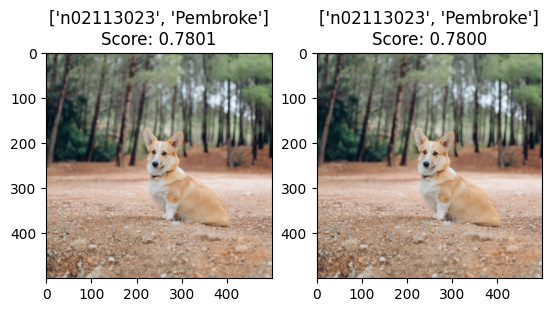

In [44]:
import json
from torchvision.io import read_image


preprocess = MaxVit_T_Weights.IMAGENET1K_V1.transforms()

with open("imagenet_class_index.json") as labels_file:
  labels = json.load(labels_file)


dog1 = read_image("dog1.jpg")
tensor = preprocess(dog1).unsqueeze(dim=0)

torch_model.eval()
with torch.inference_mode():
    torch_output = torch_model(tensor)

torch_class_id = torch_output.argmax(dim=1).item()

jax_array = jnp.asarray(tensor.permute(0, 2, 3, 1), device=jax.devices("cpu")[0])
flax_model.eval()
flax_output = flax_model(jax_array)

flax_class_id = torch_output.argmax(axis=1).item()

print("Prediction for the Dog:")
print(f"- PyTorch model result: {labels[str(torch_class_id)]}, score: {torch_output.softmax(axis=1)[0, torch_class_id]}")
print(f"- Flax model result: {labels[str(flax_class_id)]}, score: {jax.nn.softmax(flax_output, axis=1)[0, flax_class_id]}")


plt.subplot(121)
plt.title(f"{labels[str(torch_class_id)]}\nScore: {torch_output.softmax(dim=-1)[0, class_id]:.4f}")
plt.imshow(dog1.permute(1, 2, 0))

plt.subplot(122)
plt.title(f"{labels[str(flax_class_id)]}\nScore: {jax.nn.softmax(flax_output, axis=1)[0, flax_class_id]:.4f}")
plt.imshow(dog1.permute(1, 2, 0))

Let's compute cosine distance between the logits:

In [45]:
expected = jnp.asarray(torch_output)

cosine_dist = (expected * flax_output).sum() / (jnp.linalg.norm(flax_output) * jnp.linalg.norm(expected))
cosine_dist

Array(0.99999857, dtype=float32)

## Further reading

- [Flax documentation: Core Exampels](https://flax.readthedocs.io/en/latest/examples/core_examples.html)
- [JAX AI Stack tutorials](https://jax-ai-stack.readthedocs.io/en/latest/tutorials.html)